In [1]:
%matplotlib inline
# Make it python 2.x and 3.x compatible
from __future__ import division, print_function

#Import modules
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import seaborn as sns
#sns.set(style="white", context="talk")

import glob as gb

import re

import datetime as dt

# Imports to calc RH and convert from IP to SI units
from metpy.calc import relative_humidity_wet_psychrometric
from metpy.units import units

mpl.rcParams['figure.figsize'] = (16, 9)

# Parse the File supplied

In [2]:
# Read all lines into a list
with open('contest_AK_BARROW-W-POST-W-ROGERS-AP_700260_12.out', 'r') as f:
    lines = f.readlines()

# Parse weather dump into a list of rows
data = []
for line in lines:
    # I thought splitting by space would do it, but no, MMDDHH is fixed-width
    # and will not have any space if double digits.
    # So let's do it on position then
    # split = re.split('\s+', line.strip())
    try:
        month = int(line[1:3].strip())
        day = int(line[3:5].strip())
        hour = int(line[5:7].strip()) - 1
        wb = float(line[7:18])
        db = float(line[19:28])
        atm = float(line[29:40])
        dirsol = float(line[41:50])
        globsol = float(line[50:])
        data.append([month, day, hour, wb, db, atm, dirsol, globsol])
    except:
        pass

In [3]:
# Make a Pandas dataframe with it
df = pd.DataFrame(data, columns=['Month', 'Day', 'Hour', 'WetBulb','DryBulb',
                                 'Atm_inHg', 'DirectSol', 'GlobalSol'])
df = df.apply(pd.to_numeric)
df['Datetime'] = df[['Month', 'Day', 'Hour']].apply(lambda s : dt.datetime(1912, *s), axis = 1)
df = df.set_index('Datetime')
df = df[['WetBulb', 'DryBulb', 'Atm_inHg', 'DirectSol', 'GlobalSol']]

In [4]:
print("Number of datapoints in BINM: {:.0f}".format(len(df)))
print("Number of days in BINM: {:.1f}".format(len(df) / 24))

Number of datapoints in BINM: 8784
Number of days in BINM: 366.0


In [5]:
if '1912-02-29' in df.index:
    print("BINM has a 29th of February")

BINM has a 29th of February


# Load the E+ EPW for the same location

In [6]:
# Load the EPW (I manually deleted line 18 in there to be faster...)
df_epw = pd.read_csv('USA_AK_Barrow-W.Post-W.Rogers.AP.700260_TMY3EPW.csv', 
                     skiprows=17)
df_epw.index = pd.DatetimeIndex(start='1988-01-01 0:00', periods=8760, freq='H')

# Convert to SI Units and visualize

In [7]:
df['Atmos Pressure {Pa}'] = df['Atm_inHg'].apply(lambda x: (x * units.inHg).to(units.Pa).magnitude)

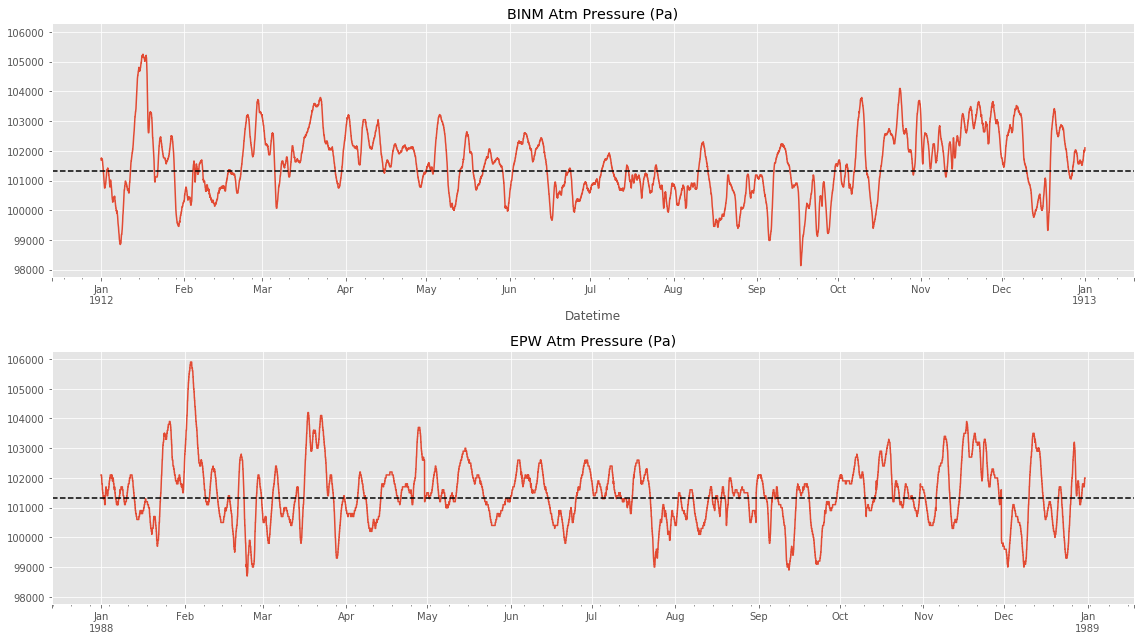

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)

df['Atmos Pressure {Pa}'].plot(figsize=(16,9), ax=ax1,
                               title='BINM Atm Pressure (Pa)')
df_epw['Atmos Pressure {Pa}'].plot(figsize=(16,9), ax=ax2,
                                   title='EPW Atm Pressure (Pa)')

# 1 atm = 101325 Pa
ax1.axhline(101325, color='k', linestyle='--')
ax2.axhline(101325, color='k', linestyle='--')


fig.tight_layout()
plt.show()

In [9]:
df['WetBulb {C}'] = df['WetBulb'].apply(lambda x: (x * units.degF).to(units.degC).magnitude)
df['DryBulb {C}'] = df['DryBulb'].apply(lambda x: (x * units.degF).to(units.degC).magnitude)

In [10]:
df['GloHorzRad {Wh/m2}'] = df['GlobalSol'].apply(lambda x: (x * units.BTU / (units.sq_ft)).to(units.watt_hour / (units.metre*units.metre)).magnitude)
df['DirNormRad {Wh/m2}'] = df['DirectSol'].apply(lambda x: (x * units.BTU / (units.sq_ft)).to(units.watt_hour / (units.metre*units.metre)).magnitude)

## Calc RH

In [11]:
df['RelHum {%}'] = df.apply(lambda row: relative_humidity_wet_psychrometric(row['DryBulb'] * units.degF, 
                                                         row['WetBulb'] * units.degF,
                                                         row['Atm_inHg'] * units.inch_Hg), axis=1)
df['RelHum {%}'] = df['RelHum {%}'].apply(lambda x: x.magnitude)

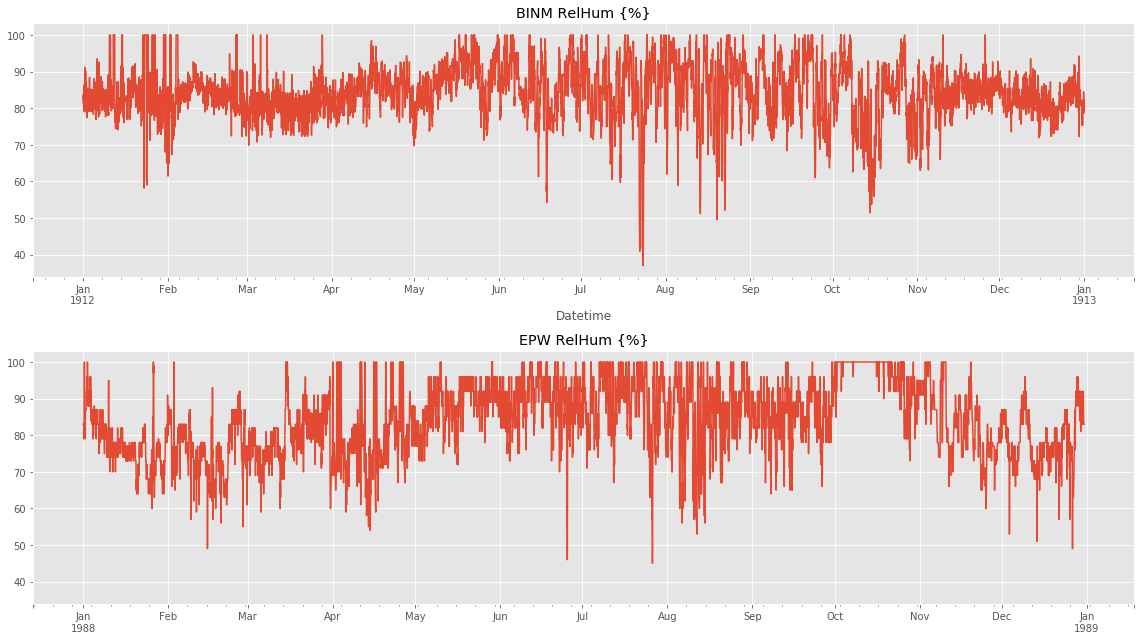

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)

col = 'RelHum {%}'

df[col].plot(figsize=(16,9), title='BINM {}'.format(col), ax=ax1)
df_epw[col].plot(figsize=(16,9), title='EPW {}'.format(col), ax=ax2)
fig.tight_layout()
plt.show()

## Radiation

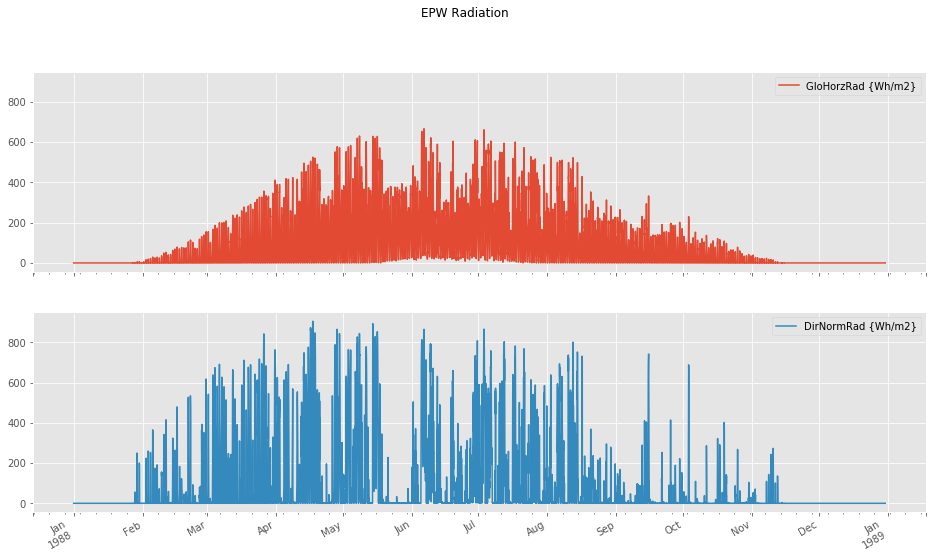

In [13]:
df_epw[['GloHorzRad {Wh/m2}','DirNormRad {Wh/m2}']].plot(subplots=True, 
                                                         sharey=True,
                                                         title='EPW Radiation')
plt.show()

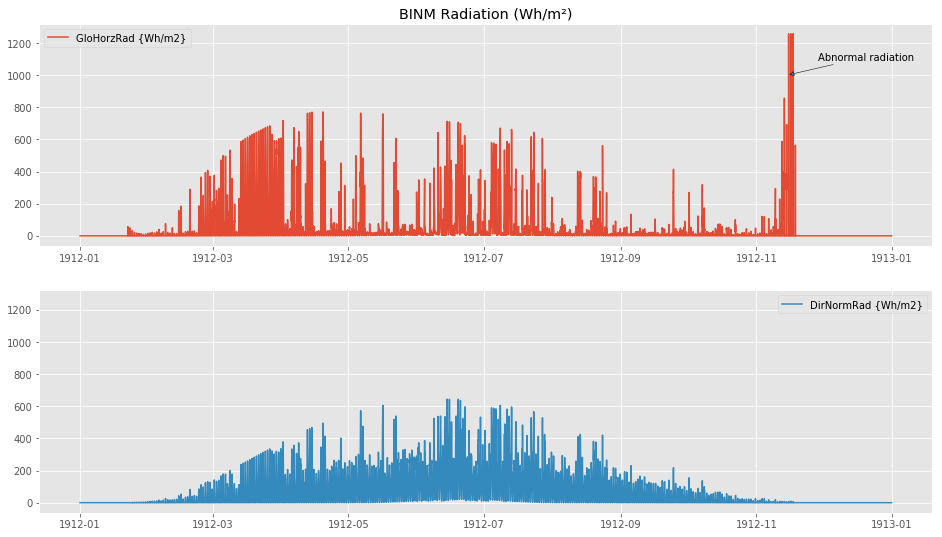

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)

# Can't use pandas plot wrapper because it doesn't work with date2num
ax1.plot(df.index, df['GloHorzRad {Wh/m2}'], label='GloHorzRad {Wh/m2}')
ax2.plot(df.index, df['DirNormRad {Wh/m2}'], label='DirNormRad {Wh/m2}',
         color='#348abd')
#df[['GloHorzRad {Wh/m2}']].plot(ax=ax1, title='BINM Radiation')
#df[['DirNormRad {Wh/m2}']].plot(ax=ax2)

ax1.annotate('Abnormal radiation', xy=(md.date2num(dt.datetime(1912,11,15)), 1000), 
             xytext=(30,15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>',
                                                                         ec='k'))

ax1.set_title('BINM Radiation (Wh/m²)')
ax1.legend()
ax2.legend()

plt.show()

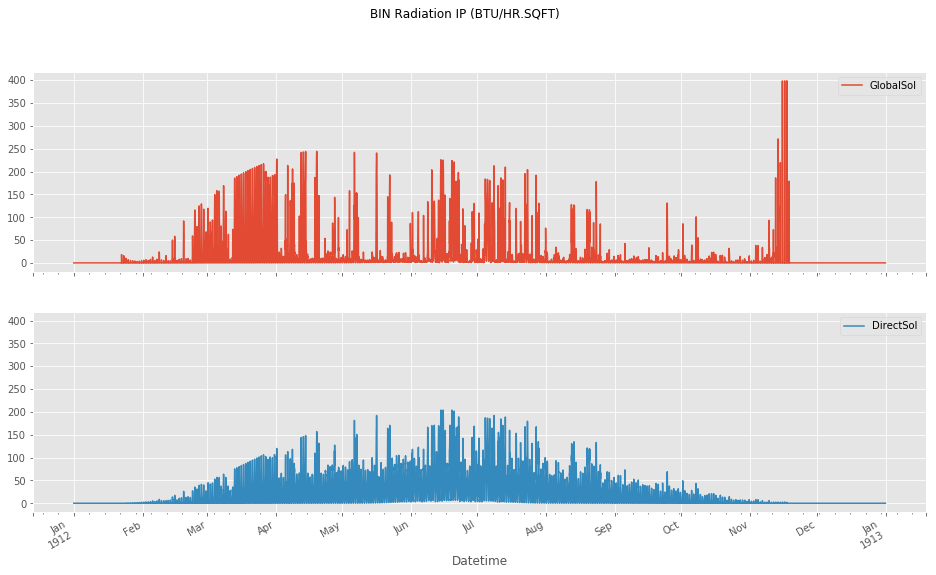

In [15]:
df[['GlobalSol', 'DirectSol']].plot(figsize=(16,9), subplots=True, sharey=True,
                                    title='BIN Radiation IP (BTU/HR.SQFT)')
plt.show()

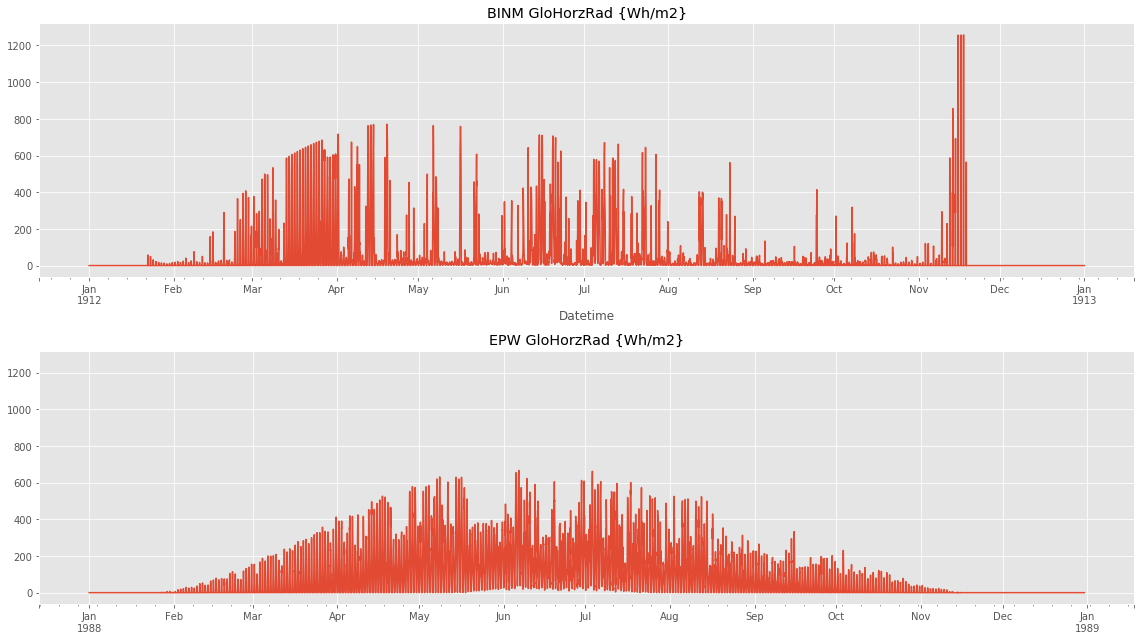

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)

col = 'GloHorzRad {Wh/m2}'

df[col].plot(figsize=(16,9), title='BINM {}'.format(col), ax=ax1)
df_epw[col].plot(figsize=(16,9), title='EPW {}'.format(col), ax=ax2)
fig.tight_layout()
plt.show()

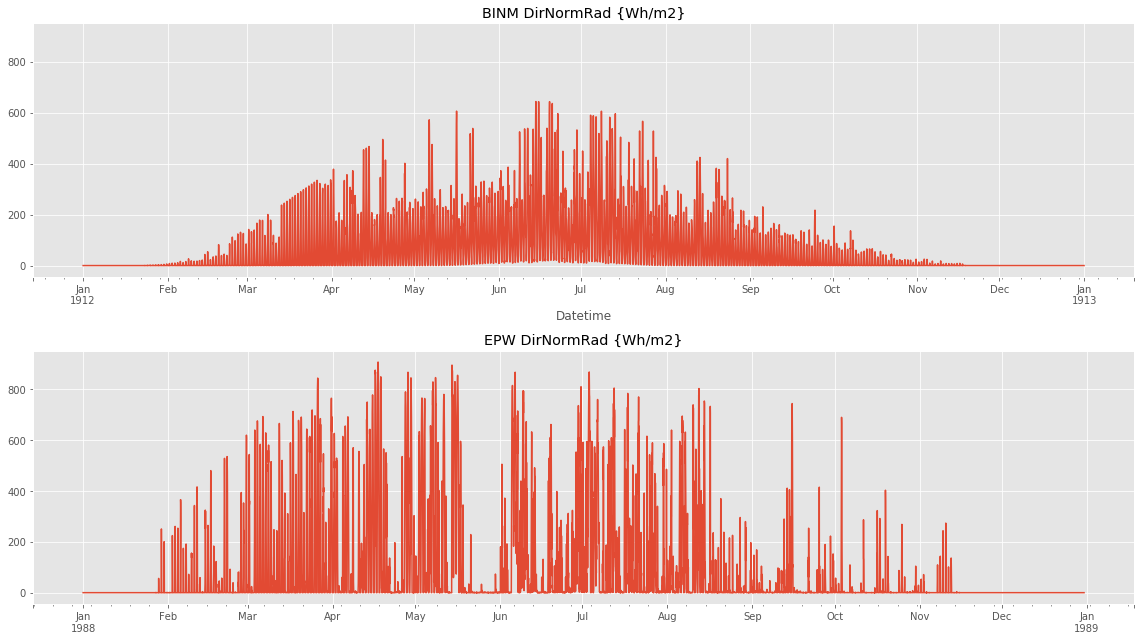

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)

col = 'DirNormRad {Wh/m2}'

df[col].plot(figsize=(16,9), title='BINM {}'.format(col), ax=ax1)
df_epw[col].plot(figsize=(16,9), title='EPW {}'.format(col), ax=ax2)
fig.tight_layout()
plt.show()

## Calculate number of days without any sun

In [18]:
n_days = (df['GloHorzRad {Wh/m2}'].resample('D').max() == 0).sum()
print("{:.0f} Days without any sun".format(n_days))

64 Days without any sun


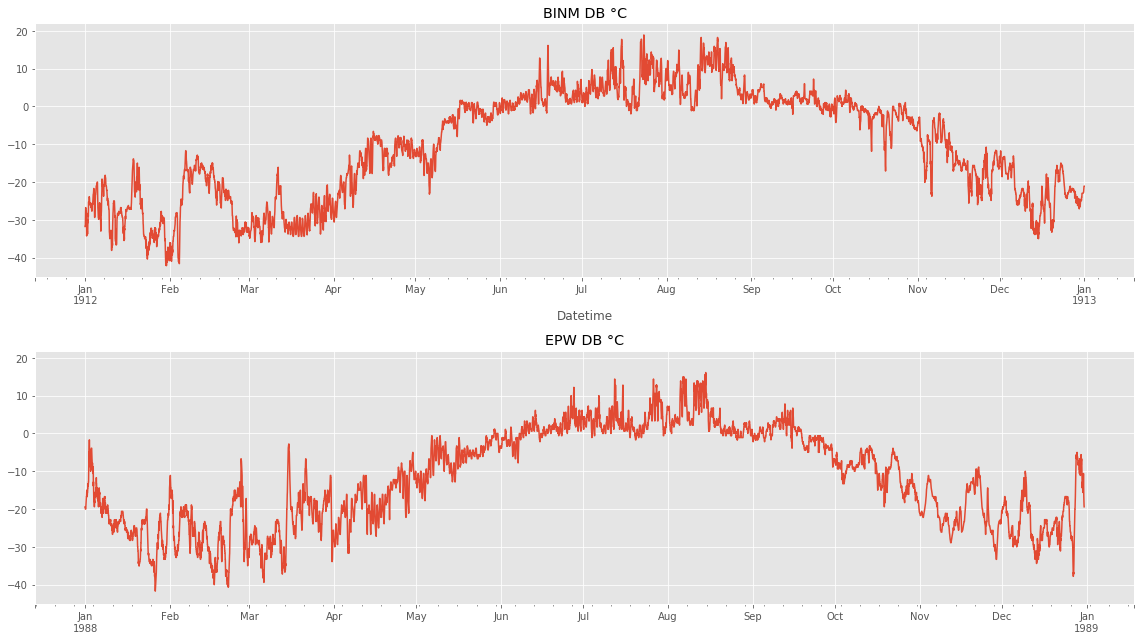

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)

col = 'DryBulb {C}'
df[col].plot(figsize=(16,9), title='BINM DB °C', ax=ax1)
df_epw[col].plot(figsize=(16,9), title='EPW DB °C', ax=ax2)
fig.tight_layout()
plt.show()

In [20]:
import seaborn as sns
sns.set_style('whitegrid')

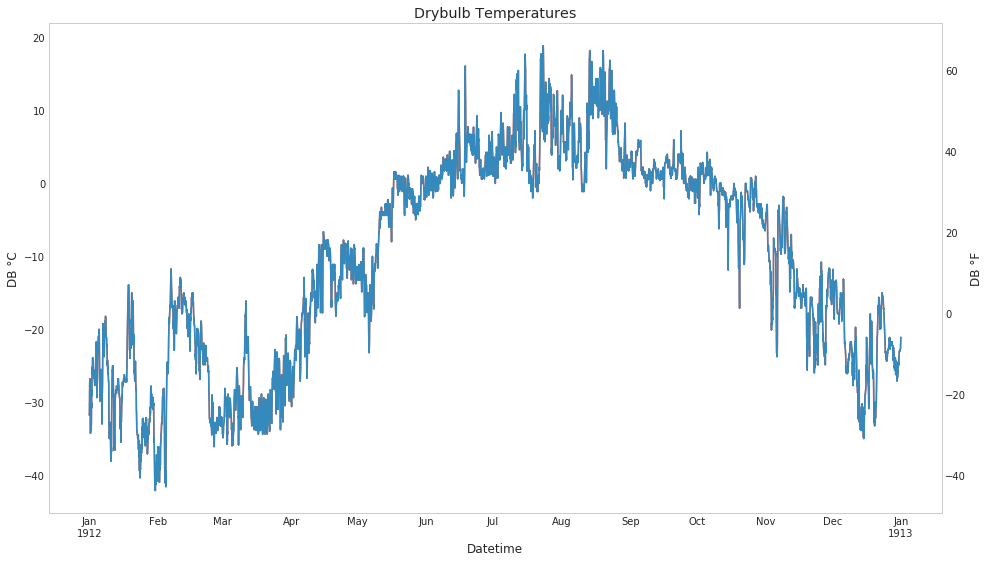

In [21]:
fig, ax = plt.subplots()
df['DryBulb {C}'].plot(figsize=(16,9), title='Drybulb Temperatures', ax=ax)
axbis = df['DryBulb'].plot(figsize=(16,9), ax=ax, secondary_y=True)
ax.set_ylabel('DB °C')
axbis.set_ylabel('DB °F')
ax.grid(False, which='both')
axbis.grid(False, which='both')